In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar  
import math

In [2]:
N = norm.cdf


In [3]:
# import sympy as sp
# import sympy.stats
# n = sympy.stats.Normal('n', 0, 1)


In [4]:
from scipy.special import erf
print(erf(1))

0.8427007929497148


In [5]:
print(N(1))
print(norm.rvs())

0.8413447460685429
-0.6170292558989992


## Setting up the params

In [25]:
option = {"T": 1, "x0": 250, "K": 100, "r": 0, "sigma": 0.6}


In [26]:
option['x0']

250

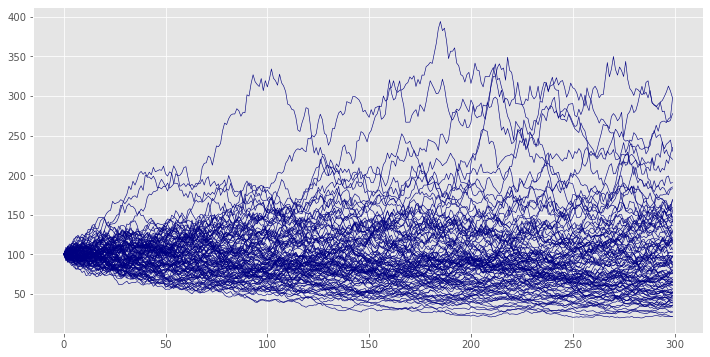

In [27]:
# geometric bwornian motions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

steps = 300
num_plots = 100
Range = []
Values = [100]

sigma = option['sigma']
T = option['T']

plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 0.6

fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 1))))


Range = np.arange(steps) 

all_paths = []

for i in range(0, num_plots):

    for i in range (1, steps):
        dx = sigma * Values[-1] * norm.rvs() * np.sqrt(T / steps)

        y = Values[-1] + dx

        Values.append(y)
    all_paths.append(Values)
    ax.plot(Range, Values)
    Values = [100]

In [28]:
def delta_BS_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1) - 1

def delta_BS_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    return N(d1)

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T)* N(-d2) - S * N(-d1)

### This is the process of BS call replication (below):

In [29]:
# delta_BS_put(100,100,0.5, 0, 1)
last_price = []
replicated_payoff = []
true_payoff = []

S0 = option['K']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']

asset = 0
initial_usdc = 200
usdc = initial_usdc
prev_asset = 0

for i in range(len(all_paths[:])):
    asset = 0
    initial_usdc = 200
    usdc = initial_usdc
    prev_asset = 0
    
    for j in range(len(all_paths[i])):
        t = (T / steps) * j
        prev_asset = asset
        asset = delta_BS_call(all_paths[i][j], K, T - t, r, sigma)
        usdc = usdc - (asset - prev_asset) * all_paths[i][j] 
#         print(asset, usdc)

    last_price.append(all_paths[i][-1])
    replicated_payoff.append(asset*all_paths[i][-1] + usdc - initial_usdc)
    
    true_payoff.append(max(0, all_paths[i][-1] - K) - BS_CALL(S0, K, T, r, sigma))

# print(all_paths[1][-1])
# print(asset*all_paths[1][-1]+ usdc)
        

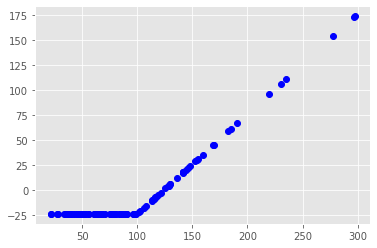

In [30]:
plt.plot(last_price, true_payoff, 'bo', )


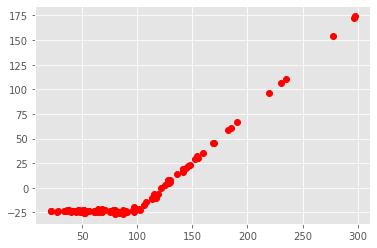

In [31]:
plt.plot(last_price, replicated_payoff, 'ro')

In [32]:
# This function is correct
def BS_root_put(x0, S, K, T, r, sigma):
    TV0 = 2 * x0
    z1 = -(np.log(S/K) + (r - 0.5*sigma**2)*T)/np.sqrt(T)/sigma

    
    first_part = (np.exp(-r*T) * TV0) * N(z1)
    _r = r/2
    _sigma = sigma / 2
    z2 = z1 - _sigma * np.sqrt(T)
    second_part = (np.exp(-r*T) * TV0*np.sqrt(S/K)) * (np.exp(-0.5 * _sigma**2 * T)*np.exp(_r*T)) * N(z2)
    
    return first_part - second_part
    


In [33]:
def new_way_BS_delta_root_put(x0, S, K, T, r, sigma):
    z1 = -(np.log(S/K) + (r - 0.5*sigma**2)*T)/np.sqrt(T)/sigma
    _r = r/2
    _sigma = sigma / 2
    z2 = z1 - _sigma * np.sqrt(T)
#     print(z1)
    return -(np.exp(-r*T) * x0 / np.sqrt(K*S)) * (np.exp(-0.5 * _sigma**2 * T)*np.exp(_r*T)) * N(z2)

In [34]:
# delta_BS_put(100,100,0.5, 0, 1)
last_price = []
replicated_payoff = []
true_payoff = []

# x0 = 50
# y0 = x0 / K


# S0 = option['K']
x0 = option['x0']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']

for i in range(len(all_paths[:])):
    asset = 0  
    initial_usdc = 0
    usdc = initial_usdc
    prev_asset = asset
    
    for j in range(len(all_paths[i])):
        t = (T / steps) * j
        prev_asset = asset
        asset = new_way_BS_delta_root_put(x0, all_paths[i][j], K, T-t, r, sigma)
        usdc = usdc - (asset - prev_asset) * all_paths[i][j] 
        print(asset, usdc)

    last_price.append(all_paths[i][-1])
    replicated_payoff.append(asset*all_paths[i][-1] + usdc - initial_usdc)
    
    true_payoff.append(max(0, (2*x0) - (2*np.sqrt(x0**2 / K))* np.sqrt(all_paths[i][-1]) ) - BS_root_put(x0, K, K, T, r, sigma))

# print(all_paths[1][-1])
# print(asset*all_paths[1][-1]+ usdc)
        

-1.194996852291375 119.4996852291375
-1.101201584791717 109.70055048340375
-1.153962524443214 115.07804541990069
-1.1902452132463963 118.71507496473124
-1.1025749069970736 109.5611300580878
-1.038965259627392 102.71354231700784
-0.9665344418818616 94.6315033435578
-1.0252785570781573 100.99741046613256
-1.0100242144114715 99.33198381899587
-0.9941412676622325 97.58434680358299
-1.018419236908051 100.22386611152683
-1.0317154356301845 101.66007185697714
-1.0084135131829932 99.11442658842262
-0.9925937558929138 97.37276839694904
-0.9707362858123798 94.94031832196097
-1.0493343393419454 103.35783024507302
-0.9778148371961316 95.42765478869762
-0.8988193468002181 86.31205745543105
-0.8820702250214388 84.36265239775999
-0.9101746699269427 87.58603545187071
-0.8881469781087281 85.03106343196201
-0.983745822710771 95.59685806305238
-0.939624538912777 90.61305996790823
-0.888661484596287 84.70587922645058
-0.7915868183476819 72.85806682606498
-0.8039836719785467 74.36051187394052
-0.7329261157

-1.6495257939379684 146.0787574289038
-1.8325804955871405 160.80137566231068
-1.8771704167697454 164.33591703115414
-1.7867330814805684 156.94171577637604
-1.7656981940291332 155.20883775418696
-1.6968493779873401 149.40080562388042
-1.6208834946648003 142.82199311513546
-1.709290278299687 150.25482029138163
-1.5315028259828911 134.36783195221014
-1.5295821899717132 134.196038750751
-1.6616535143629845 145.49374058526598
-1.713256504610703 149.83390944488423
-1.6362574316450715 143.1854260729358
-1.7290789760588892 150.95801778479102
-1.6811238071882155 146.8759258190968
-1.654112007040133 144.5548177389495
-1.5288845265113733 133.32686779801745
-1.514313272682546 132.01352547836993
-1.575432719429349 137.4116681174687
-1.6263713920355178 141.83634665966673
-1.6310273547564595 142.24030696316146
-1.6204175439745432 141.31618214971212
-1.5408533981291475 134.1976204007034
-1.5469263247496527 134.74003826132744
-1.6888323193936166 146.83970948502704
-1.6506263836447455 143.5397130292701


-2.772434553155703 229.76949897537713
-2.8588472337539064 234.4659932452214
-2.805710994025382 231.518644265907
-2.864819895097876 234.72902011916833
-2.892207636257133 236.20265120263338
-3.001799129275879 241.8675265168855
-2.9952293444705447 241.52682229552454
-3.0036406633541723 241.96199632596466
-2.930805937089817 238.08673254774854
-2.8969430375829224 236.26078274156123
-2.773686264059254 229.30080992198947
-2.618300923328837 220.0111365541532
-2.78604979737179 229.45535026261703
-2.805476761281466 230.54218359943607
-2.893358554462135 235.306025648384
-2.872380763158911 234.1591196092133
-2.834294216806568 232.04578434843108
-2.9885013692384144 240.13390424421587
-3.098815060176451 245.6888339771427
-3.0253132341304365 241.8803073402688
-2.9692051422783114 238.90892426944265
-3.170016027655597 248.7742653500164
-3.1236011768166505 246.451295495415
-3.14645667096591 247.58617668599322
-3.172814363943902 248.88289290120636
-3.208175867432477 250.60049250668055
-3.2953968935183946

-2.0975182881311287 176.6849893153328
-2.1219727602900513 178.52905539050406
-2.262597927347676 188.6852231077283
-2.259643754805224 188.47148796876274
-2.214567095102278 185.16102623187518
-2.2299398559656725 186.2855502611881
-2.2683520567927475 189.06426169095735
-2.465941792933032 202.50002566078572
-2.479613003300068 203.42644673733054
-2.4401097797631968 200.71258866000684
-2.604538508811271 211.4295396759176
-2.5131583814325147 205.28586053844026
-2.3799458861256126 195.930347248412
-2.2927510171152288 189.63138990356666
-2.337901361563457 192.85052421923393
-2.36829996338962 194.9994261246759
-2.3667977121911297 194.89307817662524
-2.31862731885036 191.42818493360357
-2.2231403696253884 184.3492178796524
-2.2719332460921415 187.91633834147564
-2.3885628506193552 196.14922000007059
-2.480052754143265 202.4305594921766
-2.6403906404194095 212.89233535722803
-2.7340949620789003 218.82376824561481
-2.586554650709613 209.0033331152203
-2.5332789847981374 205.39171606266459
-2.508845

-1.07908633045995 105.49389199246586
-0.9474720995021136 90.67368761348646
-0.9897633354105915 95.33594593825114
-0.8589495624032897 79.91706939674516
-0.910186326256754 85.79557717566428
-0.9102977852574324 85.80836290756262
-0.8371890607622985 77.0943505455789
-0.8469944450492607 78.25675153533112
-0.789409187537234 71.21400656763731
-0.8290238681509706 75.95406729766803
-0.82001064437225 74.87053374429333
-0.8365474471184393 76.84054279773099
-0.8514399773755557 78.60037894347965
-0.9271464250264911 87.20305040529233
-0.9187185913810332 86.24141158338274
-0.9862255136220474 93.69052354868704
-0.994306548459682 94.57869916248495
-0.9182066412159671 85.89629137413816
-0.7963781125361603 71.08563001493397
-0.7259469387691267 62.18169686669945
-0.7103703953943157 60.1952707761766
-0.7463750689595003 64.69193823620556
-0.7071144527594749 59.67868915912327
-0.7048825821274068 59.393415183942125
-0.738558593909252 63.61439117964654
-0.8285335241328643 74.35041048014503
-0.8611709981477988 

-1.4373840054688034 127.10260004524929
-1.5209536906532728 134.58642836220935
-1.5093103744931664 133.53919529646151
-1.5219197269395037 134.66867896588002
-1.680415851214233 148.11951125714324
-1.585121281769734 139.76224911641836
-1.6923139471768278 148.830074972735
-1.653125381335153 145.46944169725404
-1.5912788729237504 140.0513208063658
-1.6440408152392478 144.59336977939583
-1.7768579200996242 155.53467086955337
-1.7421573246052768 152.6415699785612
-1.661629949353114 145.74202346722592
-1.6798229657491688 147.29198208074166
-1.5253717960847553 133.42730225919937
-1.4979132803410253 130.9385649599385
-1.4839610092562703 129.6676020149723
-1.5817297284970353 138.28745171175194
-1.472952188448215 128.33587110231707
-1.5027389881244573 131.03436656297944
-1.4758155395739048 128.57230335120235
-1.4105599280627323 122.46957759019213
-1.5818781499423795 137.59986889178018
-1.4845448814671278 128.717743572473
-1.5643013079389463 135.80757826116823
-1.5588943916940907 135.32591500423044

-1.8500987881187883 147.8911483944724
-1.9888883367468522 159.19567503831863
-2.2375358641509746 178.11919673973645
-2.1291075709247895 169.6043010299228
-2.1682010679719714 172.64440596305988
-2.1537673914635502 171.51630558517002
-2.058806803029693 163.89199469557286
-2.1488659519759463 170.95504605201145
-2.0561588853980535 163.49190449846822
-2.111204241117421 167.86245699329237
-2.123600778425467 168.84446913214913
-2.353736141678616 185.96996336353266
-2.276998547373187 180.12764929913035
-2.29341401401231 181.37323736529197
-2.2945355861446792 181.4584194901345
-2.1603148397363037 170.87259530587392
-2.3342501772488995 183.97053374540616
-2.4457485920635222 192.11550223142143
-2.3895619899885534 187.93871745350367
-2.4721363301374364 193.94160011968913
-2.513210628751018 196.89605549360937
-2.4080017107394496 189.08338106972818
-2.400502170974861 188.524506427348
-2.7674589145449633 213.009333083071
-2.723261674106265 210.0120356037308
-2.6846025171043775 207.35306017650666
-2.7

-1.5325788875409685 140.16293823606634
-1.4802199177441069 135.46891107763727
-1.5273568538181606 139.6204676849156
-1.4740215250892592 134.82513960069195
-1.3665886852283442 124.75234000471524
-1.4347838324777518 130.97988456259176
-1.5043096703978942 137.16383366493437
-1.566520283129616 142.57053463602062
-1.562955842727979 142.260243992194
-1.5074081622121593 137.32141408195798
-1.7854209381318087 159.64341168418073
-2.013513199362752 176.53289302347082
-1.957509708942392 172.30066279707594
-2.035689512641492 178.05056104436633
-2.0481633759726012 178.96444798379918
-2.0898001201077485 181.97220930385888
-2.0934094756546906 182.2327605170389
-2.120820537926765 184.1936877321144
-2.187027962890258 188.8241351067729
-2.28740954684682 195.6062735363578
-2.2999892414575336 196.45301866886052
-2.3007286161479046 196.50280635827087
-2.3986007399197287 202.87523560652892
-2.189066644775854 188.18581754298225
-2.2251402622961693 190.6847653957239
-2.191643164263988 188.3356151242914
-2.047

-1.692132232414933 137.99452290586976
-1.9329991364072878 157.2998993826021
-1.8485525024700795 150.3509901047231
-1.8935456354931421 154.00538748005332
-1.7240299091991986 139.50320545013827
-1.6476772870990002 132.81484705521146
-1.6162761214820685 130.03657951328776
-1.6718370473489685 134.87256066771033
-1.7025968157640479 137.52646867383143
-1.788118699909274 144.72241677987506
-1.5703640602819409 125.15484037399517
-1.5766091233817503 125.7151898158026
-1.376326259715754 106.60899804088635
-1.286267276413691 97.77177379097853
-1.2191069457059496 91.03929269508795
-1.2552149550272447 94.61799634360278
-1.4338815719415723 111.38109765414355
-1.4750405170357355 115.19640645042271
-1.5214783386486588 119.44337411795172
-1.4992214960304675 117.39370940641278
-1.3664265438664307 104.66620946191617
-1.369718266239106 104.98145105560626
-1.4480522279176813 112.31215786180267
-1.5652147016736744 122.91072900602448
-1.511423714604466 117.96628523526321
-1.5570328510523967 122.1051942480367

-1.8738837132736386 139.71422371474972
-1.7842865091251732 131.61749546645552
-1.8596409036596442 138.33834709754646
-1.9165930415683359 143.36979427398197
-1.868256564813359 139.05401099125677
-2.0599558860546185 155.57811771081958
-2.127524606488133 161.33541665784273
-2.174633273940535 165.31940921399882
-1.963590565808237 146.6926801926187
-1.891060764994304 140.19586586909267
-1.892492258869368 140.32426322146208
-1.572065684312328 109.95082900096897
-1.6213699681818625 114.59148276068696
-1.574927247109003 110.1833092693843
-1.7439358037347852 125.81827341690034
-1.7813467658934754 129.26361932425078
-1.6840407371524964 120.15301750404367
-2.0680896752686695 154.03701669353674
-1.993255350352589 147.33649396970094
-1.9389405310163208 142.42042854622397
-1.7475035726193078 124.56016088962657
-1.46079022289385 96.70127763833462
-1.5388939171767368 104.21888273617401
-1.4619369149402601 96.73076659808027
-1.3570417221949649 86.38287976191779
-1.0456956745405763 54.469012321035876
-1

-0.7486320962796185 61.75832989910787
-0.8273493369825605 71.10965237639942
-0.6908714593325659 53.68127467172724
-0.5551653882797623 34.88874861208776
-0.5496021098849465 34.115969931193725
-0.5603503812919667 35.59793352281023
-0.6146180789084927 42.82982006050068
-0.7228969101100613 56.39191389414273
-0.7111964006321779 54.91755675345283
-0.6577858444489294 47.98632822647499
-0.5885799048004531 38.6343798177556
-0.6359942300778578 44.860062487185985
-0.689627088752834 51.6888958869947
-0.6202878512935194 42.50843381501015
-0.5811143909606813 37.20100614808924
-0.5663963233859818 35.18975339126156
-0.5355803303763075 30.898104587185216
-0.5528375793119181 33.27390801062625
-0.4499521889871126 18.104104571555148
-0.4897507061765146 23.80710361405359
-0.5151991307060878 27.390172702918342
-0.5074837652553698 26.29899740173483
-0.42018510493989325 13.179501365786317
-0.42815331870774226 14.36902161066098
-0.4092662049228251 11.511360087343373
-0.5034249329163216 24.83098866268944
-0.394

-1.2454042665229197 97.75442377750271
-1.3993976354931286 112.30060399133899
-1.404628775687807 112.79402742642485
-1.4148969073843702 113.75964388481667
-1.2745924882053168 99.95636094989592
-1.1276126866850753 84.77273424914263
-1.269402806315393 98.74868975276381
-1.1444610297636977 85.91567691325265
-1.109058546558642 82.23593547750636
-1.449527658205591 113.95845169383887
-1.4265501646621601 111.80175125584748
-1.4744711126090295 116.2351744784834
-1.3449780048777034 103.76363235184746
-1.5332619031255765 120.88606794889758
-1.5198004378290264 119.6564850210607
-1.603913382320078 127.15147541520123
-1.7858054060788713 142.51943144089745
-1.7837521559245766 142.34574812030692
-1.7295517233031086 137.68501715065474
-1.7849691450098886 142.37655706048804
-2.015425441415506 160.629980036229
-1.9776357298070266 157.60125492043954
-1.993676889707392 158.88187385399902
-1.9483507320538258 155.21264670542575
-1.908586258356785 151.9541245646103
-1.8999171654871454 151.2414565269372
-2.042

-3.7190922355097635 268.15576904715164
-3.694751591995879 267.05460112228195
-3.6151236872315082 263.29143531516957
-3.627256309297543 263.8612218554238
-3.649859295936811 264.9100574134803
-3.533031178335997 259.12497304650327
-3.538597224761732 259.3998430442144
-3.4899706853218087 256.9308273241062
-3.489324462922506 256.89798976825244
-3.450664676428026 254.88891809338602
-3.505243935505586 257.63953628877897
-3.634731174047354 263.7119681390118
-3.732450773783974 268.0592833740355
-3.7124508007703314 267.1596484801813
-3.8116484919198816 271.3938134358244
-3.9725169188439287 277.71737982191854
-4.049202008092798 280.6195650874216
-4.034750021093035 280.0685319969395
-4.0594640300867955 280.9996816336615
-3.9939748813670324 278.4499020014538
-4.060441602049617 280.9544650275495
-4.072575009169225 281.40908564227044
-4.042607587561334 280.26920066129276
-4.0163661092676675 279.2576518944858
-3.9061942682431114 274.7664938965933
-3.846655962708931 272.2629484970677
-3.799779751204182

-0.747799118268367 60.72016176156967
-0.7286426012167482 58.32361088693824
-0.6265502593698971 44.79176571954656
-0.5769449799831418 38.01705124588128
-0.6790925612455205 51.138745923436126
-0.6375336301107173 45.672938343134355
-0.6474718353730956 46.971906612072715
-0.5638053537364504 35.4730267589724
-0.48084502398861706 23.429436254836776
-0.43353815589765016 16.325624142913945
-0.4504572428793245 18.83280029214903
-0.44497335636079316 18.017424405291244
-0.34815355160075895 2.4701970629703833
-0.28259382159420265 -8.720516221280745
-0.30315573880231966 -5.285021416981594
-0.31828121336141796 -2.7961676769266597
-0.314514594168909 -3.417579433731287
-0.38438929865927923 7.4216237418284585
-0.34530482668068924 1.1616302763517519
-0.3893372567807654 7.954344229089051
-0.38245075802014 6.88694715776423
-0.40360513579504675 10.108968083531291
-0.40104855738026096 9.71910227564511
-0.4046927536220489 10.272835215392817
-0.35168126540971734 1.8720926932552047
-0.3118774195115591 -4.65630

-1.6509642840251058 134.97654674521712
-1.669338815103559 136.5711812043751
-1.5612830632781984 126.87079222450603
-1.685269857274094 137.58832188874064
-1.7743786760171374 145.08809376375822
-1.6750690930572845 136.46883550441234
-1.767850707832787 144.301666762301
-1.8091752966152799 147.74899876818242
-1.7123222634011006 139.42539059011708
-1.9326789195480945 157.15891741193875
-1.918486375268518 156.011108935926
-1.809551518018098 146.90364239940718
-1.9297724726739758 156.60663738717423
-1.920695835413176 155.87158390786982
-1.8793982822371071 152.48367328807623
-2.1028793130948205 169.64945708949804
-2.020589426420588 163.16641915045327
-2.2614189649588967 180.82948536865365
-2.164652320586265 173.51489771975272
-2.2986401580880313 183.24902147117987
-2.364222776811848 187.9229607933101
-2.482484713726022 196.05328727128997
-2.511270118832411 198.01631351644681
-2.395344908972726 189.80881103933842
-2.322697607595194 184.54404302968663
-2.2232241010381903 177.10870192989168
-2.49

-2.616350497520342 199.29181650815224
-2.6016999580347435 198.2305419290955
-2.763158927701122 209.37093590362178
-2.710876302224518 205.6944073190495
-2.8156310708896304 212.82332865950505
-2.727476478302351 206.63236491143243
-2.662242499375234 201.94658999017665
-2.5312655598456093 192.15121446755973
-2.5945969603196266 196.8122724792655
-2.5587287375474554 194.13963370148076
-2.7482562609369197 207.50035026333038
-2.552554006893955 192.8314296503567
-2.515822633752154 190.0442530030209
-2.3701822144594775 178.54443047790255
-2.068735715855751 152.99533398536346
-2.1715870767869467 161.53384580543312
-1.9712517082478442 144.1524673697468
-1.7252211735349703 121.71528003919835
-1.4680225879667697 97.06986364260544
-1.6457424893155537 113.55449974419619
-1.6453976583851855 113.52248398536004
-1.5438508600677034 103.90986560368285
-1.7194813547173575 120.02799976316717
-1.7184998601952757 119.93781085918579
-1.682328954232274 116.58898217590732
-1.4465353168477324 93.82494417070129
-1.

-1.6222473463624127 144.37633382632535
-1.614023517881024 143.66399537891613
-1.5676467785637147 139.5803962281457
-1.609309255330709 143.19760151564847
-1.6233235206624117 144.40892585573894
-1.5265519101209282 135.7571434343569
-1.5820071353829237 140.62241019032547
-1.5876460163037467 141.116338341875
-1.6379376610021072 145.4480701811132
-1.6572632435305523 147.10237860416
-1.5588430953218277 138.3871129632832
-1.5068442671972093 133.69804282978524
-1.5443778917254136 137.04035753249372
-1.4599053608451056 129.294065918042
-1.5378757525501325 136.2570502861071
-1.5746260337593498 139.49931058691462
-1.5642086660860892 138.57669189511145
-1.6103486022014464 142.60151425443968
-1.61337850006479 142.86564401818273
-1.56432461976208 138.51695762004516
-1.5927831351460493 141.01677077375282
-1.4551290748476495 128.34679579301323
-1.3988224955251742 123.06207392345979
-1.422267018265231 125.24536240249891
-1.21462708943432 104.44811483118104
-1.1524032928935435 98.07307429092002
-1.10516

-0.14578242770729502 -41.31972321242271
-0.1782358285824658 -36.27823641813171
-0.1737663837151241 -36.973920562122935
-0.14518539751152706 -41.543048451311215
-0.11788603975071306 -46.03876205009946
-0.10627006980114258 -47.976359083143855
-0.11169942645688645 -47.079802110291496
-0.08790970166866678 -51.13503167677763
-0.07599038586936739 -53.20213875208162
-0.05639148797137479 -56.72757365958623
-0.04305386475152497 -59.201766439496666
-0.046309059145884866 -58.6054760456196
-0.07418205462445786 -53.816078040115116
-0.08038562292245671 -52.76481232192175
-0.09587633422719061 -50.20954581660604
-0.10805041098756611 -48.2401225282856
-0.09990852820144021 -49.567599132196584
-0.15342865872740624 -41.37878105336888
-0.11702728411591189 -47.15176799000775
-0.0787858827464309 -53.52515091334701
-0.09982254127389231 -50.13666746405042
-0.10524144035800251 -49.27261454975128
-0.11759061178283862 -47.33848624910036
-0.10028601048989629 -50.097923030958356
-0.05872159661518742 -57.15605065629

-1.6432201852422524e-14 -73.55470254025137
-7.138895607585535e-15 -73.55470254025326
-4.0091834389453435e-18 -73.55470254025475
-7.201390110833649e-21 -73.55470254025475
-7.477862900572401e-30 -73.55470254025475
-3.486431671558618e-37 -73.55470254025475
-1.2905708624146019e-62 -73.55470254025475
-2.0688313479840192e-134 -73.55470254025475
-1.194996852291375 119.4996852291375
-1.1269260957449503 112.47400954596836
-1.0546892852290328 104.756649238351
-1.0605120372879262 105.3769643200981
-1.056530262517862 104.95195855619565
-1.1789609263674041 117.28986496879537
-1.1254510824603174 111.76213646812104
-1.2274098958401312 121.81598723095351
-1.2574194328582975 124.73621439857419
-1.247343500911109 123.75123063742309
-1.2959124014829133 128.39953508276176
-1.4134893316927717 139.10319511662942
-1.3918104978401742 137.11119657184972
-1.2626518386263315 124.56427082683483
-1.1739075872872258 115.59497007489725
-1.2156502820766906 119.73591091880486
-1.2769801167443728 125.65876027128768
-1.

-2.1894895559794167 180.00743721304934
-2.2530306558746895 184.61031862767615
-2.2467346410007676 184.1529494523303
-2.246093528839463 184.1063275381434
-2.3051289094968213 188.32414188688549
-2.2809008397834374 186.57837925280268
-2.3575736167297867 191.9759815273476
-2.165370858881184 177.59627659062258
-2.0804199814155853 171.06795902562627
-2.220908979128132 181.41755068827234
-2.322414703105525 188.66954949489744
-2.2679381277210826 184.70735421219803
-2.068819310596183 169.30417527866993
-1.9252930166127642 157.7047193244822
-1.9145997666592485 156.8371754654563
-1.7976894931706935 147.01121179130132
-1.6909734596782449 137.74896611987342
-1.4712305694144598 117.37479103906203
-1.3957329859838428 110.21067322920828
-1.3726259822380922 108.00200438993605
-1.3108790190065656 101.98601150992629
-1.441249893648371 114.19741634604239
-1.5087587301486545 120.39687957628666
-1.6119529294370694 129.59416531804374
-1.5558652820705898 124.51064728379262
-1.552032768510813 124.1627623492159

-4.826919836008338 304.32311852127975
-4.7607266907154475 302.5340972589944
-4.756450732871035 302.41828703709103
-4.630527816238673 298.81870670269444
-4.708957920369917 300.9872755479686
-4.911814893975066 306.14404286750334
-4.951906756160529 307.1470714013992
-5.02201553156661 308.85295200270036
-4.983883472260058 307.9105913700225
-4.885754943700041 305.38638542054764
-4.945481745374586 306.8863302167784
-5.020141301177499 308.7064797609895
-5.119355961008048 311.03311901946273
-5.208797265516055 313.05976257127116
-5.287987010500725 314.8012992700942
-5.200402178150797 312.8091137774903
-5.380633493265406 316.6397283234909
-5.402679880558562 317.10462267886106
-5.490429538997652 318.89687185691764
-5.467889362944806 318.432555743714
-5.419419142083734 317.4158490251569
-5.482634931494418 318.71184416590086
-5.379924618790889 316.52434234204287
-5.483087372772938 318.64021553525293
-5.4395814812100935 317.73330503527666
-5.431694342772337 317.5683648658219
-5.456078462059289 318.0

-2.8674494137255535 232.09282713088814
-2.728852668357633 223.89719527191244
-2.7057121048824033 222.51634290351888
-2.673733606037866 220.5847492953873
-2.5378656725088953 211.97153872511814
-2.3081476466016073 196.20629369471482
-2.340075793723148 198.37552797066704
-2.488105424913451 207.94531321255027
-2.3669663295350967 199.7773006373229
-2.3283276294829878 197.13578292939692
-2.4261302153619395 203.6092672301912
-2.5152225103637478 209.33412115572972
-2.3200212513403593 195.92173806852315
-2.215426962456509 188.47396789984774
-2.1255299272718857 181.87446485013672
-2.2674556083293256 191.82137878665912
-2.3366521624153553 196.5639236218666
-2.225781634207914 188.673733770848
-2.339475392364824 196.47071655850303
-2.3251723502249204 195.48437817874353
-2.2737103631810123 191.8716695705942
-2.2908436550118374 193.06856178365865
-2.411578833620835 201.17715362847514
-2.350570492257469 196.99225499633013
-2.3166675967678825 194.63854665174483
-2.3556731196796994 197.31390986310214
-2

-0.8803340695103052 62.10050768239602
-0.7003806736302497 40.85480185257089
-0.7433211775546532 45.84398673390151
-0.8806638208962274 61.080294215176785
-0.7669321578466276 47.990430161841445
-0.7380375503562734 44.63401700860634
-0.9020486023327776 62.68316733050193
-1.0255472686402656 75.77588314105986
-0.9312994805421703 65.50483958544514
-0.8376656641270926 55.00651701716999
-0.6918641868994678 37.86215908186289
-0.8283830588557538 53.196340409258944
-0.7840135597356327 48.144957095519885
-0.9585322360519223 66.97545911379169
-1.0290578912369528 74.43163662485595
-1.0196572330427478 73.43542530776826
-1.0483093847759897 76.44702531258793
-0.949962368502488 65.82552936963971
-0.9353198112226644 64.23818233793529
-0.9918112758003857 70.26378048319314
-0.9920830490124677 70.29275693536839
-0.7583579360369134 43.63883079745966
-0.7480341666513992 42.45865909701859
-0.8886785118989143 57.87145869845819
-0.9540780767193309 64.90637240481658
-0.9081611492022063 59.90699817419788
-0.904034

-0.8984830383704016 86.16174803790292
-0.8192391142293722 76.60658079787125
-0.8026355011578555 74.58632542508772
-0.8334166025381248 78.26777266399849
-0.8596297768928666 81.35824560310995
-0.8556732075185007 80.89085562182815
-0.8888248052700114 84.73826963527199
-0.8262647914961201 77.23199558019336
-0.808880170549852 75.1264912120254
-0.7641479509167021 69.5723680789807
-0.7419273123504094 66.77857728198914
-0.6754562858194718 58.085894012983516
-0.7612111096999369 68.74383719426497
-0.6767320047302783 57.711754105349385
-0.5884390476950113 45.51794725364584
-0.5558153574708041 40.913355215941415
-0.6613702000337076 54.814750678873644
-0.6839247561555707 57.74361560342057
-0.7323612688401435 63.85451166416075
-0.7615305391827294 67.47300683122506
-0.7558543058510754 66.76678016862111
-0.733107628114805 63.90055572253235
-0.7174553458963246 61.91092398529038
-0.7059208644438986 60.43526266726955
-0.5805580598680025 43.10334783382679
-0.589808197857658 44.37390962806647
-0.5435768928

-1.7583004591562552 153.48146010319047
-1.9242915926966242 166.28966035850252
-1.8365224161013274 159.3041061353965
-1.9577705594341344 168.56178196795724
-1.9526834660426826 168.1724769145384
-1.8674463861267947 161.4512006977129
-1.7837067539923803 154.65036391473976
-1.721234239441588 149.46289770072477
-1.911617645017394 164.27091580740907
-1.9361838528359852 166.166636476378
-1.9449812792395775 166.8438351565951
-2.1492824118763996 181.52043042565458
-2.194632483972331 184.73039363874057
-2.297362680832432 191.75600502035496
-2.2983202493649686 191.8215168434999
-2.201714209807701 184.98643620735538
-2.1049685132568947 177.90872572236984
-2.2514068566785554 188.110045206806
-2.2326971197762546 186.79746708558756
-2.241922795072962 187.44311913664737
-2.2864820239945263 190.5170077954047
-2.497263712936236 204.0573095838037
-2.3860803000162596 196.63172980111824
-2.327732025349212 192.65382559649788
-2.213503002535102 184.55459929245978
-2.371373920328089 195.17533525398306
-2.1567

-0.0102265861749142 -65.36864943257018
-0.006080164644169777 -65.97588612919519
-0.002650384634777175 -66.48960834454063
-0.005155211876627501 -66.12907915184843
-0.004273577166165996 -66.25526040866777
-0.0025604034792632716 -66.50164444954109
-0.0004550066868327505 -66.81680436674662
-0.00010220017247394607 -66.87081499731185
-9.450728390265565e-05 -66.87196979495874
-1.6568665845410304e-05 -66.88385795520267
-9.74135237999557e-07 -66.88630062701363
-2.0140367798766123e-08 -66.88645416288709
-3.247510102548524e-11 -66.8864575233224
-6.582993779773798e-13 -66.88645752855626
-8.750782682078705e-14 -66.88645752864556
-4.3978825533992057e-20 -66.88645752865928
-9.123780624088402e-24 -66.88645752865928
-1.194996852291375 119.4996852291375
-1.0846745302663203 107.88266880453733
-1.0862529120843611 108.0487504106946
-1.0160028437211934 100.40028068308894
-0.9488037883484935 92.83297458864625
-0.8855621483703381 85.47330274970437
-0.8806247328880095 84.89727982054102
-0.7925187732620632 74.1

-2.624945599929375 221.61320502300285
-2.7039049772464527 226.13592273556878
-2.7738006214911284 230.04102086204097
-2.710849330620271 226.43911923924404
-2.8529360806058466 234.16073056624248
-2.8059829260901545 231.56250479354367
-2.8328267139137218 233.0344289420552
-2.663804650149285 223.16730653215643
-2.8041006249959786 230.95382322425448
-2.91339599739811 236.78398070664306
-2.75986800257861 228.11054911178775
-2.8135334756847366 231.08550082299814
-2.8217991774849365 231.5426710720937
-2.617463912077452 219.3587992644796
-2.720599808984461 225.28736084781832
-2.7001652810576444 224.10307348226357
-2.73935057380452 226.34364578698265
-2.6324398028587788 219.9844706809865
-2.7009657195086025 223.9637861432546
-2.6177343539272186 218.97940891883667
-2.557352886384373 215.28159436956443
-2.5563429359817604 215.2196764648857
-2.647011119272827 220.6046871617296
-2.719412265299386 224.79711043434784
-2.8210853264833182 230.47510128723275
-2.7860812047760537 228.49355415951027
-2.7199

-2.3614486924855576 196.8419967516086
-2.3082082539170177 193.1774830228939
-2.5099784257575006 206.15543449133563
-2.421159842676896 200.26200531473796
-2.4627108353809453 202.98256026180331
-2.565549668879463 209.4881629748248
-2.65529706764395 214.99623424114068
-2.6504997480558408 214.70105640221203
-2.558676572162103 208.8636884493009
-2.5735140243744357 209.80293725404155
-2.675603813202377 216.04623190207582
-2.6854203989348457 216.64504381143757
-2.725387365669398 219.05125229394415
-2.6079727165421067 211.68060017616983
-2.740068825725003 219.60692131455912
-2.7608387342287104 220.84523988218007
-2.8247790837402977 224.57512801143002
-2.9188369890162664 229.88344423999192
-2.9371187501140503 230.9093130832324
-2.938406931311807 230.98163425176188
-2.9455425833700986 231.38158498404158
-2.8887361212091536 228.12776707354712
-2.8009197220896707 222.93165998061835
-2.875228831792624 227.21720764929833
-2.8209208322523174 224.02040817823993
-2.847842116886052 225.59146288195447
-2

-1.7347916238821528 162.51292097308024
-1.6975490362312522 159.45407705899223
-1.6762290444525423 157.6882156713624
-1.7487031552734622 163.53181979906262
-1.751687637627791 163.77228422834935
-1.7158256039480826 160.84272185320015
-1.6869142842075637 158.4543480104464
-1.7778655495042186 165.72007257980093
-1.8430244056493799 170.80387807416702
-1.6964738603684995 158.72750475444272
-1.6976551380860794 158.82483949807175
-1.8200664834563745 168.4688209255145
-1.726921589342103 160.87124308939497
-1.7835552161899366 165.39700139873236
-1.8198359354536353 168.25922420577012
-1.7303214829843991 160.95855635786998
-1.610896916343444 150.77277799913705
-1.553367576713185 145.75705722921327
-1.5054915208781587 141.50516205543306
-1.493056139911805 140.3952251159071
-1.4802248085556102 139.2440242290358
-1.5321248744538667 143.810666302814
-1.474776861871376 138.65222905662884
-1.2737385836488924 119.08506912822676
-1.2924666879069862 120.89447945671127
-1.3933668321120105 130.26527499437577

-0.8277956064992763 67.59498583314068
-0.8361378404283201 68.5707517472292
-0.8823093295194446 73.85875521000358
-0.9014457618720663 76.03156891262495
-1.008774083146043 87.67344886801206
-0.9708635510370874 83.49650124478441
-0.9866335861440084 85.2224022605403
-1.1633234895260185 103.24475702612949
-1.2362961208935304 110.48569093552959
-1.312985349650172 117.88418996897916
-1.2776488308214753 114.43036964491753
-1.2646301670093647 113.15167141894408
-1.389140495542067 124.84551453680213
-1.612815430333279 144.29082884980343
-1.4458305058827068 128.91061951366729
-1.5376343385416495 137.10450471087577
-1.4233595671461914 126.49124161771658
-1.291974664252427 113.70523726603723
-1.298951944264267 114.38263594531766
-1.2292278359173838 107.43978003760722
-1.1222190629310875 96.35191545293242
-1.232453719625187 107.31747741968385
-1.1977832739926386 103.82454340867346
-1.1793570863835077 101.9554927990214
-1.1279357230837879 96.63916478404681
-1.3189938182158154 115.0753058647301
-1.359

-1.6603831081438827 138.9071702917358
-1.7320801114095465 145.00740012646386
-1.6749898257660896 140.06143890148923
-1.6412809181519572 137.10929499076335
-1.7820751093708274 148.92497012380707
-1.775475410848485 148.3696971263637
-1.6238490816799565 135.0022010043633
-1.47477231222336 121.23628380917425
-1.413326783724777 115.45089544111065
-1.4736938758288347 121.03043440646395
-1.5403200611773933 127.06563950560573
-1.4759698267806194 121.11856997170258
-1.6030106195802178 132.41809355456382
-1.5404244019434896 126.74291358992596
-1.5203611349741977 124.91188949494808
-1.6166685167173778 133.45362269144192
-1.3892002499733935 111.8352895887467
-1.3402021369998138 107.10673958257809
-1.2395118607507307 97.07765054596143
-1.262655126791189 99.36626236301483
-1.2871702062396266 101.77234014910529
-1.3633040108533199 109.07321169668421
-1.2138223688600998 94.05984727691953
-1.1265871756072101 85.05190706165325
-1.3358623311186593 105.29938961246452
-1.504919561385583 120.85778091215676


-0.3495788531478117 1.958752098416059
-0.3812182470429615 6.770550443823953
-0.37336926321643754 5.570665304782642
-0.3445645079409312 1.0690323848081684
-0.3589372928132429 3.2872421180844444
-0.45659775442503414 17.315161867933533
-0.4907297227273917 22.106569696176745
-0.4629448625615991 18.138308509804588
-0.5205170406850874 26.06127588072916
-0.4802948539457142 20.389435548475305
-0.5082941560216813 24.266275113577926
-0.5704296597554266 32.55459065548655
-0.6320854419246791 40.50094920355604
-0.6850998663478084 47.14570751055052
-0.7326182778410865 52.96123617425551
-0.6900885059049995 47.64876264532549
-0.7122598694577321 50.386875035053485
-0.8541924837032484 66.796497374849
-0.8653355940846286 68.0782147188342
-0.7649487963117363 56.00251024649743
-0.7911300459583346 59.11309352698639
-0.7781395721674875 57.561070824386654
-0.8161520083462565 62.02379739000489
-0.7722488969764134 56.76821537209614
-0.768076664393591 56.26799614993719
-0.7418152988845002 53.08228568730098
-0.75

-3.1418997273186693 236.6524989616441
-3.188787691531882 239.49257072074673
-3.278868618272045 244.6760080798707
-3.1892974162154437 239.2405798499817
-3.204358146841596 240.14737538847126
-3.219879113654272 241.07412030668178
-3.241151407148211 242.3291406261256
-3.196603875769261 239.62793826203497
-3.179928892502072 238.60585687601943
-3.1351218335135496 235.78189658695905
-3.128248763324693 235.34651754700488
-3.077191439004965 232.00758173048575
-3.093712884065644 233.07839096518893
-3.0608112943052834 230.90031154526116
-3.0463512380629383 229.93345312351678
-3.2135438197728736 240.00889305585767
-3.267659576033302 243.16411266600977
-3.2527360337229734 242.28572447755144
-3.200863032836596 239.1318269004506
-3.247030715910445 241.86043857989705
-3.205668852752131 239.35161832013526
-3.3639665364416387 248.07347480521537
-3.3809266878132926 248.9988678174952
-3.4220550897242807 251.18998764432692
-3.498170422095128 255.07165930564366
-3.497795460347834 255.0525274538139
-3.472581

(7.439097728910365, 150.0)

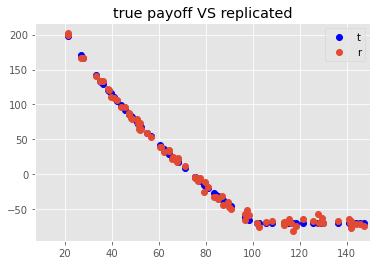

In [35]:
print(plt.plot(last_price, true_payoff, 'bo'))
print(plt.plot(last_price, replicated_payoff, 'o'))
plt.title('true payoff VS replicated')
plt.legend('tr')
plt.xlim(xmax=150)

Text(0, 0.5, 'bs root delta')

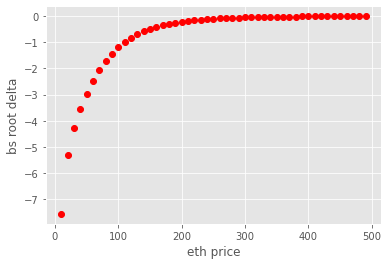

In [36]:
stock_prices = [x for x in range(10, 500, 10)]


x0 = option['x0']
S0 = option['K']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']


put_prices = [new_way_BS_delta_root_put(x0, price, K, T, r, sigma) for price in stock_prices]

print(plt.plot(stock_prices, put_prices, 'ro'))
plt.xlabel('eth price')
plt.ylabel('bs root delta')

In [18]:
from scipy.integrate import quad

In [19]:
x0 = option['x0']
S0 = option['K']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']

In [20]:
# This function works correctly

# S is the price at time t (not T)
def num_new_way_BS_delta_root_put(z, x0, S, K, T, r, sigma):
    return -(2*x0/np.sqrt(K)*(0.5/np.sqrt(S))*np.exp(0.5 * (r - 0.5*sigma**2)*T + 0.5*sigma*np.sqrt(T)*z))*norm.pdf(z)



In [21]:
x0 = option['x0']
S0 = option['K']
K = option['K']
T = option['T']
r = option['r']
sigma = option['sigma']

new_way_BS_delta_root_put(x0, K, K, T, r, sigma)


-0.24382747800708315

In [22]:
z2 = -(np.log(S0/K) + (r - 0.5*sigma**2)*T)/np.sqrt(T)/sigma

I = quad(num_new_way_BS_delta_root_put, -100, z2, args=(x0,K,K,T,r,sigma))
I

(-0.2438274780070833, 2.511738557993534e-13)